In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Using backend: pytorch


In [2]:
data = pd.read_csv('ton_iot.csv')

In [4]:
data.type.value_counts()

scanning      7140161
ddos          6165008
dos           3375328
xss           2108944
password      1365958
normal         788599
backdoor       508116
injection      452659
ransomware      72805
mitm             1052
Name: type, dtype: int64

In [8]:
df = data.drop(data[(data.type == 'mitm') & (data.type > 'ransomware')].index)

In [10]:
mitm = data[data['type'] == 'mitm']
ransomware = data[data['type'] == 'ransomware']

In [11]:
df = df.sample(frac=0.1,random_state = 42)

In [13]:
data = pd.concat([df,mitm,ransomware], axis=0, ignore_index=True)

In [14]:
data

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,1556025919,192.168.1.32,55827.0,192.168.1.186,8586.0,tcp,-,0.000000,0.0,0.0,...,0.0,0.0,-,-,-,-,-,-,1.0,scanning
1,1556294902,192.168.1.30,51524.0,192.168.1.195,80.0,tcp,http,0.022213,155.0,978.0,...,0.0,0.0,-,-,-,-,-,-,1.0,password
2,1556025887,192.168.1.32,55428.0,192.168.1.195,1314.0,tcp,-,0.000000,0.0,0.0,...,0.0,0.0,-,-,-,-,-,-,1.0,scanning
3,1556079325,192.168.1.31,58876.0,192.168.1.195,513.0,tcp,-,0.000000,0.0,0.0,...,0.0,0.0,-,-,-,-,-,-,1.0,scanning
4,1556021906,192.168.1.32,53925.0,192.168.1.133,5950.0,tcp,-,0.000000,0.0,0.0,...,0.0,0.0,-,-,-,-,-,-,1.0,scanning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271715,1556429194,192.168.1.37,38131.0,192.168.1.193,445.0,tcp,-,0.000029,0.0,0.0,...,0.0,0.0,-,-,-,-,-,-,1.0,ransomware
2271716,1556429475,192.168.1.37,44413.0,13.55.50.68,123.0,udp,-,0.012730,48.0,48.0,...,0.0,0.0,-,-,-,-,-,-,1.0,ransomware
2271717,1556429477,192.168.1.33,39296.0,203.14.129.10,123.0,udp,-,0.032825,48.0,48.0,...,0.0,0.0,-,-,-,-,-,-,1.0,ransomware
2271718,1556431523,192.168.1.37,37268.0,13.55.50.68,123.0,udp,-,0.012950,48.0,48.0,...,0.0,0.0,-,-,-,-,-,-,1.0,ransomware


In [15]:
data['src_ip'] = data.src_ip.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [16]:
data['src_ip'] = data.src_ip.apply(str)
data['src_port'] = data.src_port.apply(str)
data['dst_ip'] = data.dst_ip.apply(str)
data['dst_port'] = data.dst_port.apply(str)

In [17]:
data['src_ip'] = data['src_ip'] + ':' + data['src_port']
data['dst_ip'] = data['dst_ip'] + ':' + data['dst_port']

In [18]:
data.type.value_counts()

scanning      714995
ddos          616039
dos           337072
xss           211184
password      135923
ransomware     80109
normal         78955
backdoor       50893
injection      45396
mitm            1154
Name: type, dtype: int64

In [55]:
data['http_trans_depth'].unique()

array(['-', '1', '2', '4', '6', '7', '9'], dtype=object)

In [35]:
data.drop(columns=['ts','src_port','dst_port','http_uri','weird_name','weird_addl','weird_notice','dns_query','ssl_subject','ssl_issuer','http_user_agent','label'],inplace=True)

In [36]:
data.rename(columns={"type": "label"},inplace = True)

In [37]:
le = LabelEncoder()
le.fit(data.label.values)
data['label'] = le.transform(data['label'])

In [38]:
label = data.label

In [39]:
data.drop(columns=['label'],inplace = True)

In [40]:
scaler = StandardScaler()

In [41]:
data =  pd.concat([data, label], axis=1)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)

In [57]:
X_train

,src_ip,dst_ip,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,...,ssl_established,http_trans_depth,http_method,http_version,http_request_body_len,http_response_body_len,http_status_code,http_orig_mime_types,http_resp_mime_types,label
1220102,172.30.169.94:42256.0,192.168.1.184:443.0,tcp,-,0.000003,0.0,0.0,SHR,0.0,1.0,...,-,-,-,-,0.0,0.0,0.0,-,-,1
1486264,172.29.252.92:7845.0,192.168.1.180:45999.0,tcp,-,0.000000,0.0,0.0,S0,0.0,1.0,...,-,-,-,-,0.0,0.0,0.0,-,-,8
17089,172.27.150.106:55218.0,192.168.1.190:80.0,tcp,-,0.000260,0.0,0.0,S1,0.0,2.0,...,-,-,-,-,0.0,0.0,0.0,-,-,1
570758,172.19.0.24:58775.0,192.168.1.250:20222.0,tcp,-,0.000000,0.0,0.0,S0,0.0,1.0,...,-,-,-,-,0.0,0.0,0.0,-,-,8
2006894,172.21.225.127:38344.0,192.168.1.184:80.0,tcp,http,0.009098,152.0,171.0,SF,0.0,6.0,...,-,-,-,-,0.0,0.0,0.0,-,-,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684689,172.27.159.225:55830.0,192.168.1.1:53.0,udp,dns,0.002090,39.0,39.0,SF,0.0,1.0,...,-,-,-,-,0.0,0.0,0.0,-,-,1
6356,172.23.222.170:44741.0,192.168.1.133:4242.0,tcp,-,0.000000,0.0,0.0,S0,0.0,1.0,...,-,-,-,-,0.0,0.0,0.0,-,-,8
338212,172.22.77.121:54390.0,192.168.1.152:80.0,tcp,http,0.001335,153.0,463.0,SF,0.0,5.0,...,-,-,-,-,0.0,0.0,0.0,-,-,6
2033037,172.21.152.99:60584.0,192.168.1.33:80.0,tcp,-,0.000097,0.0,0.0,REJ,0.0,1.0,...,-,-,-,-,0.0,0.0,0.0,-,-,0


In [58]:
encoder = ce.TargetEncoder(cols=['proto','service','conn_state','dns_qclass','dns_qtype','dns_rcode','dns_AA','dns_RD','dns_RA','dns_rejected','ssl_version','ssl_cipher','ssl_resumed','ssl_established','http_method','http_version','http_status_code','http_orig_mime_types','http_resp_mime_types','http_trans_depth'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [59]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [60]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [62]:
X_train

,src_ip,dst_ip,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,...,http_trans_depth,http_method,http_version,http_request_body_len,http_response_body_len,http_status_code,http_orig_mime_types,http_resp_mime_types,label,h
1220102,172.30.169.94:42256.0,192.168.1.184:443.0,-0.141989,-0.326613,-0.086422,-0.026786,-0.022974,-1.370432,-0.007051,-0.017000,...,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,1,"[0.031656479263249236, -0.010544215749821386, ..."
1486264,172.29.252.92:7845.0,192.168.1.180:45999.0,-0.141989,-0.326613,-0.086422,-0.026786,-0.022974,1.205621,-0.007051,-0.017000,...,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,8,"[0.031656479263249236, -0.010654428878323154, ..."
17089,172.27.150.106:55218.0,192.168.1.190:80.0,-0.141989,-0.326613,-0.086419,-0.026786,-0.022974,-1.518812,-0.007051,-0.011864,...,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,1,"[0.031656479263249236, -0.008891018822294875, ..."
570758,172.19.0.24:58775.0,192.168.1.250:20222.0,-0.141989,-0.326613,-0.086422,-0.026786,-0.022974,1.205621,-0.007051,-0.017000,...,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,8,"[0.031656479263249236, -0.010764642006824922, ..."
2006894,172.21.225.127:38344.0,192.168.1.184:80.0,-0.141989,2.202699,-0.086330,-0.026782,-0.022969,0.500845,-0.007051,0.008678,...,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,1,"[0.031656479263249236, 0.0010281627428641899, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684689,172.27.159.225:55830.0,192.168.1.1:53.0,1.404392,0.040903,-0.086401,-0.026785,-0.022973,0.500845,-0.007051,-0.017000,...,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,1,"[0.031656479263249236, -0.010130916517939759, ..."
6356,172.23.222.170:44741.0,192.168.1.133:4242.0,-0.141989,-0.326613,-0.086422,-0.026786,-0.022974,1.205621,-0.007051,-0.017000,...,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,8,"[0.031656479263249236, -0.010764642006824922, ..."
338212,172.22.77.121:54390.0,192.168.1.152:80.0,-0.141989,2.202699,-0.086408,-0.026782,-0.022961,0.500845,-0.007051,0.003542,...,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,6,"[0.031656479263249236, -0.00037705464553334443..."
2033037,172.21.152.99:60584.0,192.168.1.33:80.0,-0.141989,-0.326613,-0.086421,-0.026786,-0.022974,-0.412740,-0.007051,-0.017000,...,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,0,"[0.031656479263249236, -0.010654428878323154, ..."


In [65]:
G = nx.from_pandas_edgelist(X_train, "src_ip", "dst_ip", ['h','label'],create_using=nx.MultiGraph())

In [66]:
G = G.to_directed()

In [67]:
G = from_networkx(G,edge_attrs=['h','label'] )

In [68]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [69]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [70]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [71]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 10)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [72]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [73]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [74]:
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [75]:
G.ndata['h'].device


device(type='cuda', index=0)

In [76]:
G.edata['h'].device


device(type='cuda', index=0)

In [77]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(G.edata['label'].cpu().numpy()),
                                                 G.edata['label'].cpu().numpy())

In [78]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [79]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [80]:
import os

In [81]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())


for epoch in range(1,15000):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        th.save(model.state_dict(), os.path.join('./model', 'epoch-{}.pt'.format(epoch)))
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

Epoch: 100  Training acc: 0.5622228384017944
Epoch: 200  Training acc: 0.698897123336792
Epoch: 300  Training acc: 0.7005963325500488
Epoch: 400  Training acc: 0.7232459187507629
Epoch: 500  Training acc: 0.7733508348464966
Epoch: 600  Training acc: 0.7604178786277771
Epoch: 700  Training acc: 0.7459869980812073
Epoch: 800  Training acc: 0.7555640935897827
Epoch: 900  Training acc: 0.7852099537849426
Epoch: 1000  Training acc: 0.7912085652351379
Epoch: 1100  Training acc: 0.7631102800369263
Epoch: 1200  Training acc: 0.7781992554664612
Epoch: 1300  Training acc: 0.7793076038360596
Epoch: 1400  Training acc: 0.8022056221961975
Epoch: 1500  Training acc: 0.7667208313941956
Epoch: 1600  Training acc: 0.7944477796554565
Epoch: 1700  Training acc: 0.8050265908241272
Epoch: 1800  Training acc: 0.8065757751464844
Epoch: 1900  Training acc: 0.800061821937561
Epoch: 2000  Training acc: 0.8021285533905029
Epoch: 2100  Training acc: 0.8087337017059326
Epoch: 2200  Training acc: 0.8202875256538391

KeyboardInterrupt: 

In [82]:
X_test = encoder.transform(X_test)

In [83]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [84]:
X_test

,src_ip,dst_ip,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,...,ssl_established,http_trans_depth,http_method,http_version,http_request_body_len,http_response_body_len,http_status_code,http_orig_mime_types,http_resp_mime_types,label
1410016,172.27.214.71:31971.0,192.168.1.46:4372.0,-0.141989,-0.326613,-0.086422,-0.026786,-0.022974,1.205621,-0.007051,-0.017000,...,0.032353,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,8
200517,172.26.161.210:42846.0,192.168.1.184:443.0,-0.141989,-0.326613,0.525077,-0.026786,-0.022974,-1.533133,-0.007051,-0.006729,...,0.032353,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,1
1428994,172.16.225.203:62698.0,192.168.1.169:16353.0,-0.141989,-0.326613,-0.086422,-0.026786,-0.022974,-0.412740,-0.007051,-0.017000,...,0.032353,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,8
1078536,172.19.241.97:49470.0,192.168.1.184:443.0,-0.141989,-0.326613,0.523792,-0.026786,-0.022974,-1.533133,-0.007051,-0.006729,...,0.032353,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,1
256376,172.20.96.45:44682.0,192.168.1.190:80.0,-0.141989,2.202699,-0.085307,-0.026779,-0.022920,0.500845,-0.007051,0.003542,...,0.032353,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507930,172.26.220.2:60854.0,192.168.1.190:80.0,-0.141989,2.202699,-0.081312,-0.026778,-0.022920,-1.518812,-0.007007,-0.006729,...,0.032353,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,3
1739336,172.17.44.1:4635.0,192.168.1.152:4635.0,-0.141989,-0.326613,-0.086420,-0.026786,-0.022974,-0.412740,-0.007051,-0.017000,...,0.032353,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,2
347110,172.28.144.97:60159.0,192.168.1.190:12201.0,-0.141989,-0.326613,-0.086420,-0.026786,-0.022974,-0.412740,-0.007051,-0.017000,...,0.032353,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,8
6363,172.27.70.110:45432.0,192.168.1.184:443.0,-0.141989,-0.326613,0.532008,-0.026786,-0.022974,-1.533133,-0.007051,-0.006729,...,0.032353,0.032008,0.030573,0.031656,-0.002745,-0.00124,0.025943,-0.008069,-0.014919,1


In [85]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [86]:
G_test = nx.from_pandas_edgelist(X_test, "src_ip", "dst_ip", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(),G.ndata['h'].shape[2])

In [87]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [88]:
G_test = G_test.to('cuda:0')

In [89]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [90]:
print(str(elapsed) + ' seconds')

0.09727129400016565 seconds


In [91]:
test_pred = test_pred.argmax(1)
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [92]:
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [93]:
from sklearn.metrics import plot_confusion_matrix


In [94]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

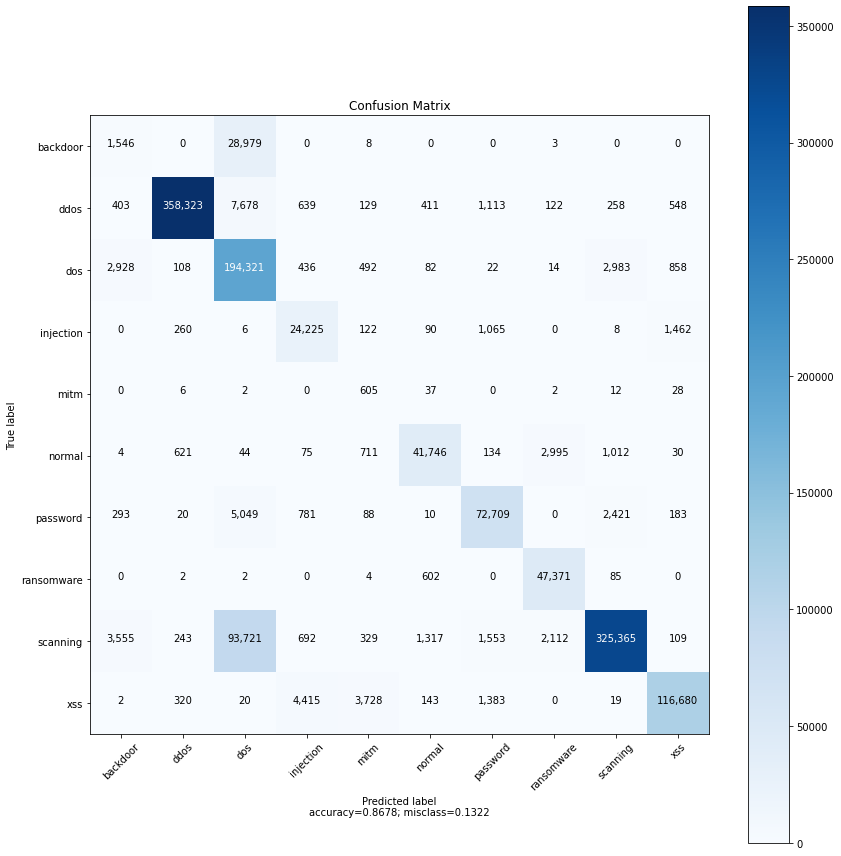

In [95]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [96]:
from sklearn.metrics import classification_report
print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

    backdoor     0.1771    0.0506    0.0787     30536
        ddos     0.9956    0.9694    0.9823    369624
         dos     0.5892    0.9608    0.7304    202244
   injection     0.7749    0.8894    0.8282     27238
        mitm     0.0973    0.8743    0.1752       692
      normal     0.9394    0.8812    0.9094     47372
    password     0.9324    0.8915    0.9115     81554
  ransomware     0.9003    0.9855    0.9410     48066
    scanning     0.9795    0.7584    0.8549    428996
         xss     0.9732    0.9208    0.9463    126710

    accuracy                         0.8678   1363032
   macro avg     0.7359    0.8182    0.7358   1363032
weighted avg     0.8959    0.8678    0.8695   1363032



In [97]:
#th.save(model.state_dict(), 'model.pt')

In [98]:
from sklearn.metrics import classification_report
print(classification_report(actual, test_pred, digits=2))

              precision    recall  f1-score   support

    backdoor       0.18      0.05      0.08     30536
        ddos       1.00      0.97      0.98    369624
         dos       0.59      0.96      0.73    202244
   injection       0.77      0.89      0.83     27238
        mitm       0.10      0.87      0.18       692
      normal       0.94      0.88      0.91     47372
    password       0.93      0.89      0.91     81554
  ransomware       0.90      0.99      0.94     48066
    scanning       0.98      0.76      0.85    428996
         xss       0.97      0.92      0.95    126710

    accuracy                           0.87   1363032
   macro avg       0.74      0.82      0.74   1363032
weighted avg       0.90      0.87      0.87   1363032



In [99]:
report = classification_report(actual, test_pred, digits=4, output_dict=True)

In [100]:
df = pd.DataFrame(report).transpose()

In [101]:
df.to_csv('unsw_ton_iot_agg_report.csv')

In [102]:
df

,precision,recall,f1-score,support
backdoor,0.177070,0.050629,0.078743,3.053600e+04
ddos,0.995610,0.969426,0.982343,3.696240e+05
dos,0.589169,0.960825,0.730439,2.022440e+05
injection,0.774878,0.889382,0.828191,2.723800e+04
mitm,0.097329,0.874277,0.175159,6.920000e+02
normal,0.939421,0.881238,0.909400,4.737200e+04
password,0.932418,0.891544,0.911523,8.155400e+04
ransomware,0.900264,0.985541,0.940974,4.806600e+04
scanning,0.979534,0.758434,0.854920,4.289960e+05
xss,0.973161,0.920843,0.946279,1.267100e+05


In [103]:
th.save(model.state_dict(), 'unsw_ton_iot_agg_mul.pt')
